In [2]:
import numpy as np
import cv2
import json
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from utils import (
    EmotionDataset,
    normalize_affine,
    Net,
    Net2D,
    draw_landmarks,
    fast_draw,
    get_indices_subset,
    train_model,
    evaluate,
    minmax_scale,
)
import matplotlib.pyplot as plt

In [3]:
landmark_train_path = "databases/custom_dataset/train/landmark_dataset.json"
landmark_test_path = "databases/custom_dataset/test/landmark_dataset.json"

image_train_path = "databases/custom_dataset/train/video_dataset/"
image_test_path = "databases/custom_dataset/test/video_dataset/"

# Finetuning Landmark model

In [5]:
# getting label2id from image folders
train_dataset = ImageFolder(image_train_path)
label2id = train_dataset.class_to_idx
id2label = {v: k for k, v in label2id.items()}
id2label

{0: 'angry',
 1: 'disgusted',
 2: 'happy',
 3: 'neutral',
 4: 'sad',
 5: 'surprised'}

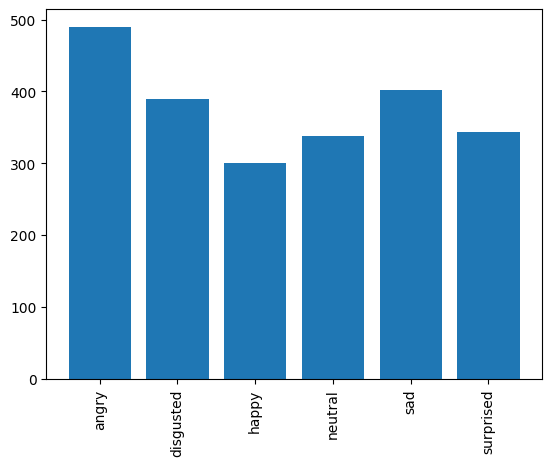

In [6]:
counts = np.bincount(train_dataset.targets)

plt.bar(id2label.values(), counts)
plt.xticks(rotation=90)
plt.show()

In [7]:
def get_state_dict(model, path,):
    new_state_dict = model.state_dict()
    old_state_dict = torch.load(path, weights_only=True)
    count = 0
    for key in old_state_dict:
        if "fc" not in key and key in new_state_dict:
            new_state_dict[key] = old_state_dict[key]
            count += 1

    model.load_state_dict(new_state_dict, strict=False)
    return new_state_dict

In [8]:
#Not Used, it creates an evaluation bias, subsequet frames has strong correlation, therefore it is like testing on the train set
def get_landmark_loaders(normalization_func, label2id, indices, batch_size=256):
    landmarks = json.load(open(landmark_train_path))
    landmarks = landmarks["Nic"]
    indices = get_indices_subset()
    train_dataset = EmotionDataset(landmarks, label2id, normalization_func, indices)
    test_dataset = EmotionDataset(
        json.load(open(landmark_test_path))["Nic"],
        label2id,
        normalization_func,
        indices,
    )

    gen = torch.Generator().manual_seed(42)
    test_dataset, val_dataset = random_split(
        test_dataset, [len(test_dataset) // 2, len(test_dataset) // 2], generator=gen
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader


def get_seq_loaders(normalization_func, label2id, indices, batch_size=256):
    """
    Folders were initially designed to be test and train folder (inside and outside environment)
    I made the design choice of merging them together
    Loaders are taken in a sequentiall manner because combining all togheter and applying random shuffle lead to
    have a frame in the train set and the subsequent one in the test/val set
    This is not good because subsequent frames are highly correlated therefore is like testing on the train set.

    In this way we do not feed subsequent frame (except for the last one) to the same set
    """
    landmarks_train = json.load(open(landmark_train_path))
    landmarks_train = landmarks_train["Nic"]

    landmarks_test = json.load(open(landmark_test_path))
    landmarks_test = landmarks_test["Nic"]

    train_data = []
    test_data = []
    val_data = []

    emotion = None
    count = 0
    for i, values in enumerate(landmarks_train):
        if not emotion:
            emotion = values["emotion"]

        if (
            i == len(landmarks_train) - 1
            or emotion != landmarks_train[i + 1]["emotion"]
        ):
            start = i - count
            if i == len(landmarks_train) - 1:
                end = i + 1
            else:
                end = i
            len_train = int(0.7 * count)
            len_val_test = int(0.15 * count)
            train_data.extend(landmarks_train[start : start + len_train])
            val_data.extend(
                landmarks_train[start + len_train : start + len_train + len_val_test]
            )
            test_data.extend(landmarks_train[start + len_train + len_val_test : end])
            count = 0
            emotion = values["emotion"]

        count += 1

    assert len(train_data) + len(val_data) + len(test_data) == len(landmarks_train)

    emotion = None
    count = 0
    for i, values in enumerate(landmarks_test):
        if not emotion:
            emotion = values["emotion"]

        if i == len(landmarks_test) - 1 or emotion != landmarks_test[i + 1]["emotion"]:
            start = i - count
            if i == len(landmarks_test) - 1:
                end = i + 1
            else:
                end = i
            len_train = int(0.7 * count)
            len_val_test = int(0.15 * count)
            train_data.extend(landmarks_test[start : start + len_train])
            val_data.extend(
                landmarks_test[start + len_train : start + len_train + len_val_test]
            )
            test_data.extend(landmarks_test[start + len_train + len_val_test : end])
            count = 0
            emotion = values["emotion"]

        count += 1

    train_dataset = EmotionDataset(train_data, label2id, normalization_func, indices)
    val_dataset = EmotionDataset(val_data, label2id, normalization_func, indices)
    test_dataset = EmotionDataset(test_data, label2id, normalization_func, indices)

    assert len(train_dataset) + len(val_dataset) + len(test_dataset) == len(
        landmarks_train
    ) + len(landmarks_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [9]:
from torch import nn
from utils import normalize_affine, normalize_face, get_indices_subset

#selected 100 landmarks
indices = get_indices_subset()

def multiple_trainings():
    results = {}
    batch_sizes = [64, 128, 256, 512, 1024][::-1]
    normalizations = [normalize_affine, minmax_scale]
    freeze_backs = [True, False]
    epochs = 1000
    for batch_size in batch_sizes:
        for normalization_func in normalizations:
            for freeze in freeze_backs:
                print(
                    f"Batch size: {batch_size}, Normalization: {normalization_func.__name__}, Freeze back: {freeze}"
                )

                train_loader, val_loader, test_loader = get_seq_loaders(
                    normalization_func, label2id, indices, batch_size
                )

                model = Net(len(label2id))

                if normalization_func == minmax_scale:
                    old_state_dict = "models/Net-minmax-pretrain.pth"
                elif normalization_func == normalize_affine:
                    old_state_dict = "model/Net-affine-pretrain.pth"

                model.load_state_dict(get_state_dict(model, old_state_dict))
                if freeze:
                    for name, param in model.named_parameters():
                        if "fc" not in name:
                            param.requires_grad = False
                device = torch.device("mps")
                model = model.to(device)

                criterion = nn.CrossEntropyLoss()
                optimizer = torch.optim.Adam(
                    model.parameters(), lr=0.0005, weight_decay=1e-3
                )
                scheduler = torch.optim.lr_scheduler.LinearLR(
                    optimizer, start_factor=1.0, end_factor=0.1, total_iters=epochs
                )

                logdir = f"logs/finetuning/{type(model).__name__}_{batch_size}_{normalization_func.__name__}_{str(freeze)}_2"
                save_path = logdir + "/" + "best_model.pth"

                train_losses, val_losses = train_model(
                    model,
                    train_loader,
                    val_loader,
                    criterion,
                    optimizer,
                    scheduler,
                    epochs,
                    device,
                    patience=np.max([batch_size // 4, 20]),
                    save_path=save_path,
                    logdir=logdir,
                )

                model.load_state_dict(torch.load(save_path))
                acc, f1, precision, recall, cm = evaluate(
                    model, test_loader, device, average="weighted", cm_norm="true"
                )
                # print model class name
                res_name = f"{type(model).__name__}_{batch_size}_{normalization_func.__name__}_subsampled_{str(freeze)}"
                print(f"Results for {res_name}:")
                print(
                    f"Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}"
                )
                print("_" * 50)
                results[res_name] = {
                    "acc": acc,
                    "f1": f1,
                    "precision": precision,
                    "recall": recall,
                    "cm": cm,
                    "train_losses": train_losses,
                    "val_losses": val_losses,
                }

    return results


#results = multiple_trainings()
#json.dump(results, open("finetuning_results3.json", "w"))

In [10]:
import json
import matplotlib.pyplot as plt

results = json.load(open("finetuning_results3.json"))

12


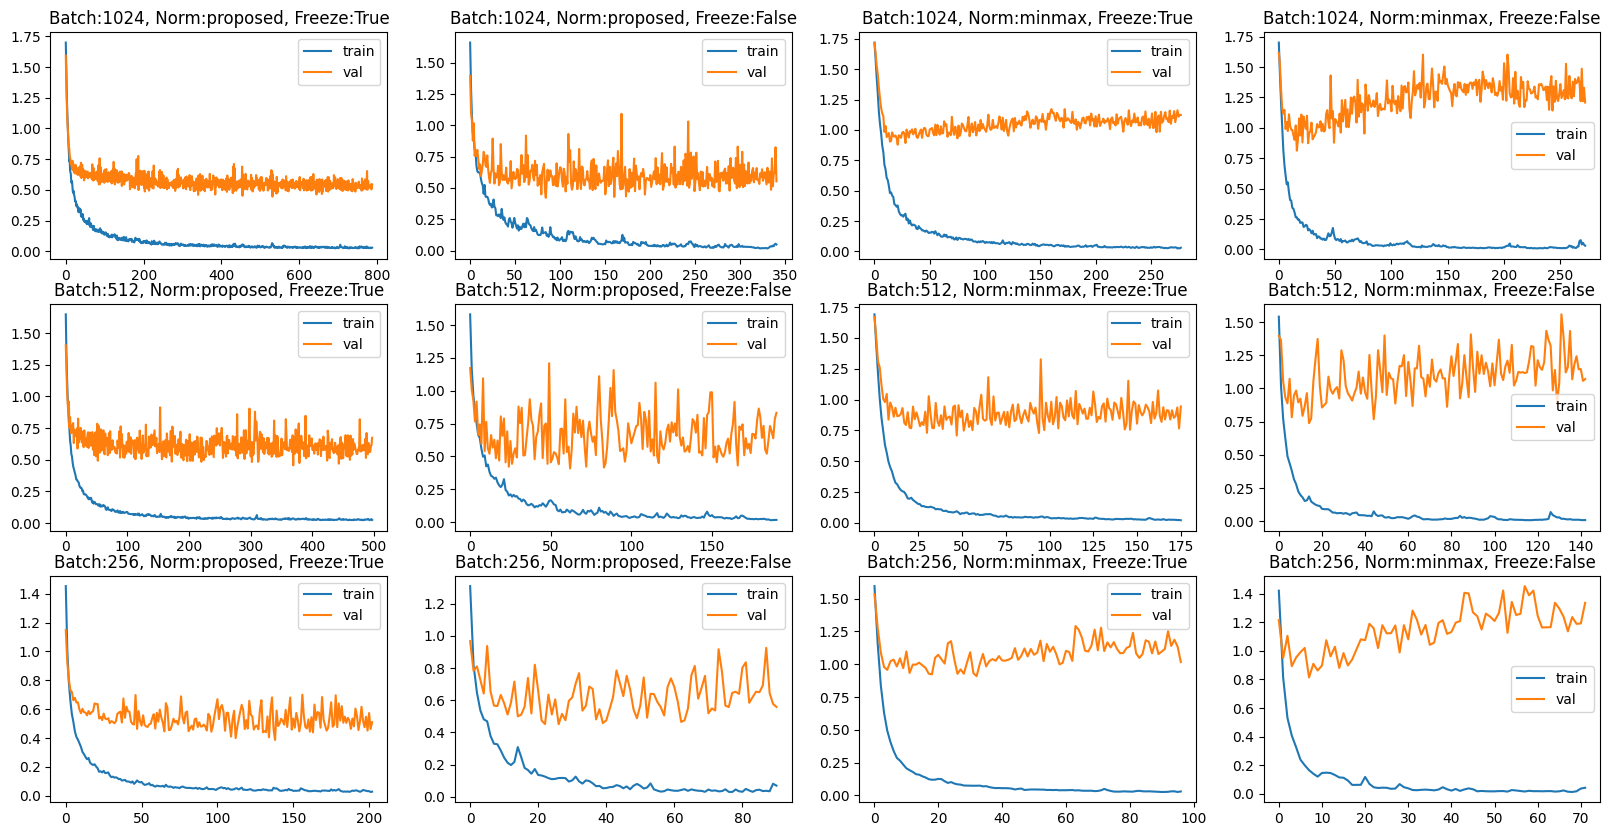

In [11]:
net_results = {k: v for k, v in results.items()}
net_results = {k: v for k, v in net_results.items() if int(k.split("_")[1]) > 128}
print(len(net_results))
fig, ax = plt.subplots(3, 4, figsize=(20, 10))
for i, (k, v) in enumerate(net_results.items()):
    ax[i // 4, i % 4].plot(v["train_losses"], label="train")
    ax[i // 4, i % 4].plot(v["val_losses"], label="val")
    _, batch, func, _, freeze = k.replace("normalize_affine", "proposed").replace("minmax_scale", "minmax").split("_")
    title = f"Batch:{batch}, Norm:{func}, Freeze:{freeze}"
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].legend()
plt.show()

In [12]:
import numpy as np

def get_best_config(results):
    # this returns the best config for each normalization function
    best_configs = {}
    for normalization_func in ["normalize_affine", "minmax_scale"]:
        best_val = 0
        best_config = None
        for k, v in results.items():
            if normalization_func in k:
                # average metrics
                metrics = np.mean([v["acc"], v["f1"], v["precision"], v["recall"]])
                if metrics > best_val:
                    best_val = metrics
                    best_config = k

        best_configs[normalization_func] = best_config

    return best_configs


best_configs = get_best_config(results)
models_path = [f"logs/finetuning/{v}/best_model.pth" for v in best_configs.values()]
models_path = [m.replace("_subsampled", "") for m in models_path]
models_path

['logs/finetuning/Net_1024_normalize_affine_True/best_model.pth',
 'logs/finetuning/Net_256_minmax_scale_True/best_model.pth']

In [13]:
import pandas as pd

df = pd.DataFrame(
    columns=[
        "Batch Size",
        "Normalization",
        "Frozen",
        "Accuracy",
        "F1",
        "Precision",
        "Recall",
    ]
)

for config, values in results.items():
    _, batch, func, _, _, freeze = config.split("_")
    if func == "normalize":
        func = "proposed"
    acc, f1, precision, recall = (
        values["acc"],
        values["f1"],
        values["precision"],
        values["recall"],
    )
    acc = np.round(acc, 3)
    f1 = np.round(f1, 3)
    precision = np.round(precision, 3)
    recall = np.round(recall, 3)
    df = pd.concat(
        [
            df,
            pd.DataFrame(
                [[batch, func, freeze, acc, f1, precision, recall]], columns=df.columns
            ),
        ],
        ignore_index=True,
    )


df

/var/folders/f1/mgyx72dd65b8kb__4m0rxs_w0000gn/T/ipykernel_66450/1313275100.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


,Batch Size,Normalization,Frozen,Accuracy,F1,Precision,Recall
0,1024,proposed,True,0.970,0.970,0.972,0.970
1,1024,proposed,False,0.931,0.931,0.935,0.931
2,1024,minmax,True,0.783,0.786,0.821,0.783
3,1024,minmax,False,0.812,0.816,0.856,0.812
4,512,proposed,True,0.956,0.956,0.959,0.956
5,512,proposed,False,0.923,0.922,0.929,0.923
6,512,minmax,True,0.848,0.849,0.877,0.848
7,512,minmax,False,0.834,0.833,0.856,0.834
8,256,proposed,True,0.964,0.964,0.966,0.964
9,256,proposed,False,0.966,0.965,0.966,0.966


In [14]:
accs, f1, prec, rec = [], [], [], []
for i in range(0, len(df) - 2, 1):
    if df.iloc[i]['Normalization'] == "proposed":
        accs.append(df.iloc[i]["Accuracy"] - df.iloc[i + 2]["Accuracy"])
        f1.append(df.iloc[i]["F1"] - df.iloc[i + 2]["F1"])
        prec.append(df.iloc[i]["Precision"] - df.iloc[i + 2]["Precision"])
        rec.append(df.iloc[i]["Recall"] - df.iloc[i + 2]["Recall"])

f"Normalized mean diff acc: {np.mean(accs):.2f}, f1: {np.mean(f1):.2f}, prec: {np.mean(prec):.2f}, rec: {np.mean(rec):.2f}"

'Normalized mean diff acc: 0.12, f1: 0.12, prec: 0.09, rec: 0.12'

In [16]:
def df_to_latex_table(df, indices = [], colors = []):
    assert len(indices) == len(colors)
    latex_code = (
        "\\begin{table}[htbp]\n\\centering\n\\begin{tabular}{|"
        + "c|" * len(df.columns)
        + "}\n\\hline\n"
    )

    # Add header
    latex_code += (
        " & ".join([f"\\textbf{{{col:^{15}}}}" for col in df.columns])
        + " \\\\\n\\hline\n"
    )

    # Add rows
    for i, row in df.iterrows():
        row_data = " & ".join([str(x) for x in row])
        if i in indices:  # Highlight first and fifth row
            latex_code += f"\\rowcolor{{{colors[indices == i]}}} {row_data} \\\\\n"
        else:
            latex_code += f"{row_data} \\\\\n"
        latex_code += "\\hline\n"

    # End the table
    latex_code += "\\end{tabular}\n\\end{table}"

    return latex_code

#latex_table = df_to_latex_table(df, indices = [0, 10], colors=["green", "yellow"])
# Save the LaTeX table to a .tex file or print it
#with open("finetuning_results3.tex", "w") as f:
#    f.write(latex_table)

# Finetuning Image Model

In [17]:
train_dataset = ImageFolder(image_train_path)
test_dataset = ImageFolder(image_test_path)

## Cropping images with face detection model

In [18]:
import os
from time import time
from tqdm import tqdm
import mediapipe as mp

# Retriving images, running face detector and saving cropped faces


def get_cropped_images(dataset: torch.utils.data.Dataset, padding=0.2):
    """
    This function takes a dataset and returns a list of cropped faces and their labels
    padding: float, padding to add to the bounding box in percentage
    """
    mp_face_detection = mp.solutions.face_detection

    images, labels = [], []
    with mp_face_detection.FaceDetection(
        min_detection_confidence=0.5
    ) as face_detection:
        for i in tqdm(range(0, len(dataset))):
            image, label = dataset[i]

            if isinstance(image, torch.Tensor):
                image = image.permute(1, 2, 0).numpy()
            else:
                image = np.array(image)

            image = cv2.cvtColor(
                image, cv2.COLOR_RGB2BGR
            )  # Made an error when saving the images
            results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

            # Process each face detection result
            if results.detections:
                for detection in results.detections:
                    # Get bounding box coordinates
                    bboxC = detection.location_data.relative_bounding_box
                    h, w, _ = image.shape
                    bbox = (
                        int(bboxC.xmin * w),
                        int(bboxC.ymin * h),
                        int(bboxC.width * w),
                        int(bboxC.height * h),
                    )
                    x_min = bbox[0] - int(padding * bbox[2])
                    y_min = bbox[1] - int(padding * bbox[3])
                    x_max = bbox[0] + bbox[2] + int(padding * bbox[2])
                    y_max = bbox[1] + bbox[3] + int(padding * bbox[3])

                    face_crop = image[y_min:y_max, x_min:x_max]

                images.append(face_crop)
                labels.append(label)
            
    return images, labels


#images, labels = get_cropped_images(train_dataset)

In [19]:
#saving cropped images
#for image, label in tqdm(zip(images, labels)):
#    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
#    label = test_dataset.classes[label]
#    os.makedirs(f"custom_dataset/train/cropped_dataset2/{label}/", exist_ok=True)
#    cv2.imwrite(f"custom_dataset/train/cropped_dataset2/{label}/{time()}.jpg", image)

### Loading Cropped Faces as torch dataset

In [26]:
def get_image_seq_loaders(label2id, batch_size=256):
    """
    Folders were initially designed to be test and train folder (inside and outside environment)
    I made the design choice of merging them together
    Loaders are taken in a sequentiall manner because combining all togheter and applying random shuffle lead to
    have a frame in the train set and the subsequent one in the test/val set
    This is not good because subsequent frames are highly correlated therefore is like testing on the train set.

    In this way we do not feed subsequent frame (except for the last one) to the same set
    """
    dataset1 = ImageFolder("databases/custom_dataset/train/cropped_dataset2", transform=None)
    dataset2 = ImageFolder("databases/custom_dataset/test/cropped_dataset2/", transform=None)

    dataset1 = [dataset1[i] for i in range(len(dataset1))]
    dataset2 = [dataset2[i] for i in range(len(dataset2))]

    train_data = []
    test_data = []
    val_data = []

    emotion = None
    count = 0
    for i, (x, y) in enumerate(dataset1):
        if not emotion:
            emotion = y

        if i == len(dataset1) - 1 or emotion != dataset1[i + 1][1]:
            start = i - count
            if i == len(dataset1) - 1:
                end = i + 1
            else:
                end = i
            len_train = int(0.7 * count)
            len_val_test = int(0.15 * count)
            train_data.extend(dataset1[start : start + len_train])
            val_data.extend(
                dataset1[start + len_train : start + len_train + len_val_test]
            )
            test_data.extend(dataset1[start + len_train + len_val_test : end])
            count = 0
            emotion = y

        count += 1

    assert len(train_data) + len(val_data) + len(test_data) == len(dataset1)

    emotion = None
    count = 0
    for i, (x, y) in enumerate(dataset2):
        if not emotion:
            emotion = y

        if i == len(dataset2) - 1 or emotion != dataset2[i + 1][1]:
            start = i - count
            if i == len(dataset2) - 1:
                end = i + 1
            else:
                end = i
            len_train = int(0.7 * count)
            len_val_test = int(0.15 * count)
            train_data.extend(dataset2[start : start + len_train])
            val_data.extend(
                dataset2[start + len_train : start + len_train + len_val_test]
            )
            test_data.extend(dataset2[start + len_train + len_val_test : end])
            count = 0
            emotion = y

        count += 1

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((96, 96)),
            transforms.Normalize(mean=mean, std=std),
        ]
    )

    class ImageDataset(Dataset):
        def __init__(self, data, label2id, transform=None):
            self.data = data
            self.transform = transform
            self.class_to_idx = {v: k for k, v in label2id.items()}

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            x, y = self.data[idx]
            y = torch.tensor(y, dtype=torch.long)
            if self.transform:
                x = self.transform(x)
            return x, y

    train_dataset = ImageDataset(train_data, label2id, transform)
    val_dataset = ImageDataset(val_data, label2id, transform)
    test_dataset = ImageDataset(test_data, label2id, transform)

    assert len(train_dataset) + len(val_dataset) + len(test_dataset) == len(
        dataset1
    ) + len(dataset2)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


#train_loader, val_loader, test_loader = get_image_seq_loaders(label2id, batch_size=256)

In [27]:
from torch import nn
from utils import Net2D


def multiple_trainings_2D():
    results = {}
    batch_sizes = [16, 32, 64, 128][::-1]
    freeze_backs = [True, False]
    epochs = 500
    for batch_size in batch_sizes:
        for freeze in freeze_backs:
            print(f"Batch size: {batch_size}, Freeze back: {freeze}")

            train_loader, val_loader, test_loader = get_image_seq_loaders(
                label2id, batch_size
            )

            model = Net2D(len(label2id))
            state_dict = get_state_dict(model, "logs/Net2D_100_64/best_model.pth")
            model.load_state_dict(state_dict)
            if freeze:
                for name, param in model.named_parameters():
                    if "fc" not in name:
                        param.requires_grad = False

            device = torch.device("mps")
            model = model.to(device)

            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(
                model.parameters(), lr=0.0005, weight_decay=1e-3
            )
            scheduler = torch.optim.lr_scheduler.LinearLR(
                optimizer, start_factor=1.0, end_factor=0.1, total_iters=epochs
            )

            logdir = (
                f"logs/finetuning/{type(model).__name__}_{batch_size}_{str(freeze)}"
            )
            save_path = logdir + "/" + "best_model.pth"

            train_losses, val_losses = train_model(
                model,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                scheduler,
                epochs,
                device,
                patience=30,
                save_path=save_path,
                logdir=logdir,
            )

            model.load_state_dict(torch.load(save_path))
            acc, f1, precision, recall, cm = evaluate(
                model, test_loader, device, average="weighted", cm_norm="true"
            )
            # print model class name
            res_name = f"{type(model).__name__}_{batch_size}_{str(freeze)}"
            print(f"Results for {res_name}:")
            print(
                f"Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}"
            )
            print("_" * 50)
            results[res_name] = {
                "acc": acc,
                "f1": f1,
                "precision": precision,
                "recall": recall,
                "cm": cm,
                "train_losses": train_losses,
                "val_losses": val_losses,
            }
            torch.mps.empty_cache()

    return results


#results = multiple_trainings_2D()
#json.dump(results, open("2Dfinetuning_results2.json", "w"))

In [28]:
results = json.load(open("2Dfinetuning_results2.json"))
import pandas as pd

df = pd.DataFrame(
    columns=["Batch Size", "Frozen", "Accuracy", "F1", "Precision", "Recall"]
)

for config, values in results.items():
    _, batch, freeze = config.split("_")

    acc, f1, precision, recall = (
        values["acc"],
        values["f1"],
        values["precision"],
        values["recall"],
    )
    acc = np.round(acc, 3)
    f1 = np.round(f1, 3)
    precision = np.round(precision, 3)
    recall = np.round(recall, 3)
    df = pd.concat(
        [
            df,
            pd.DataFrame(
                [[batch, freeze, acc, f1, precision, recall]], columns=df.columns
            ),
        ],
        ignore_index=True,
    )


df

/var/folders/f1/mgyx72dd65b8kb__4m0rxs_w0000gn/T/ipykernel_66450/2769602883.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


,Batch Size,Frozen,Accuracy,F1,Precision,Recall
0,128,True,0.793,0.783,0.806,0.793
1,128,False,0.857,0.858,0.875,0.857
2,64,True,0.766,0.761,0.785,0.766
3,64,False,0.909,0.909,0.918,0.909
4,32,True,0.770,0.765,0.787,0.770
5,32,False,0.886,0.887,0.903,0.886
6,16,True,0.768,0.763,0.790,0.768
7,16,False,0.846,0.846,0.866,0.846


In [29]:
# Create the LaTeX table code

#latex_table = df_to_latex_table(df, [3], ['green'])
#
## Save the LaTeX table to a .tex file or print it
#with open("finetuning_results2D2.tex", "w") as f:
#    f.write(latex_table)

# Performances Comparison 

In [30]:
device = torch.device("mps")

# Loading Models
baseline_model = Net2D(len(label2id)).to(device)
fast_model = Net(len(label2id)).to(device)
fast_model_minmax = Net(len(label2id)).to(device)


baseline_model.load_state_dict(
    torch.load("models/Net2D-finetuning.pth", weights_only=True)
)
fast_model.load_state_dict(
    torch.load(
        "models/Net-affine-finetuning.pth",
        weights_only=True,
    )
)
fast_model_minmax.load_state_dict(
    torch.load(
        "models/Net-minmax-finetuning.pth", weights_only=True
    )
)


landmark_train, landmark_val, landmark_test = get_seq_loaders(
    normalize_affine, label2id, indices, batch_size=256
)
landmark_train_minmax, landmark_val_minmax, landmark_test_minmax = get_seq_loaders(
    minmax_scale, label2id, indices, batch_size=256
)
image_train, image_val, image_test = get_image_seq_loaders(label2id, batch_size=256)

In [31]:
image_acc, image_f1, image_precision, image_recall, image_cm = evaluate(
    baseline_model, image_test, device, average="weighted", cm_norm="pred"
)
landmark_acc, landmark_f1, landmark_precision, landmark_recall, landmark_cm = evaluate(
    fast_model, landmark_test, device, average="weighted", cm_norm="pred"
)
(
    landmark_acc_minmax,
    landmark_f1_minmax,
    landmark_precision_minmax,
    landmark_recall_minmax,
    landmark_cm_minmax,
) = evaluate(
    fast_model_minmax, landmark_test_minmax, device, average="weighted", cm_norm="pred"
)

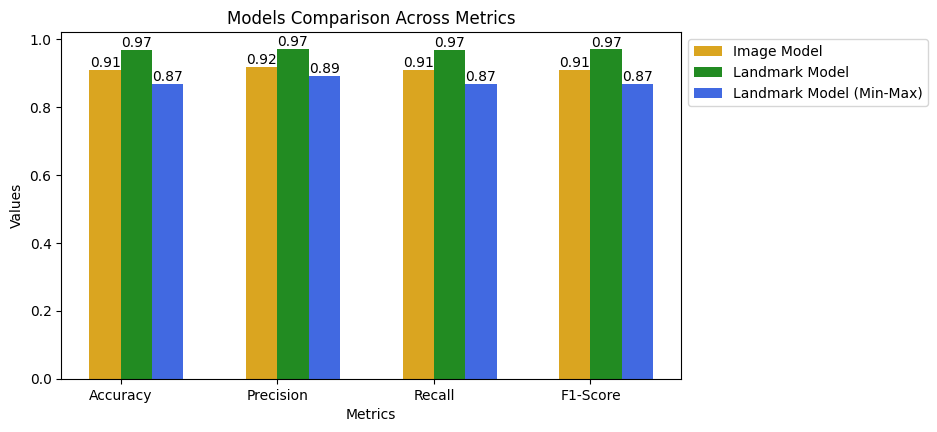

In [33]:
acc = [image_acc, landmark_acc, landmark_acc_minmax]
f1 = [image_f1, landmark_f1, landmark_f1_minmax]
precision = [image_precision, landmark_precision, landmark_precision_minmax]
recall = [image_recall, landmark_recall, landmark_recall_minmax]

metrics = np.vstack([acc, precision, recall, f1])

# Metric names for the x-axis
metric_names = ["Accuracy", "Precision", "Recall", "F1-Score"]

# Number of metrics
n_metrics = metrics.shape[0]

# Bar width
bar_width = 0.20

# X locations for the groups
index = np.arange(n_metrics)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 4.5))

# Plot bars for each model
bar1 = ax.bar(index, metrics[:, 0], bar_width, label="Image Model", color="goldenrod")
bar2 = ax.bar(
    index + bar_width,
    metrics[:, 1],
    bar_width,
    label="Landmark Model",
    color="forestgreen",
)
bar3 = ax.bar(
    index + 2 * bar_width,
    metrics[:, 2],
    bar_width,
    label="Landmark Model (Min-Max)",
    color="royalblue",
)

# Add text on top of the bars
for i, bar in enumerate(bar1):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.2f}",
        ha="center",
        va="bottom",
    )

for i, bar in enumerate(bar2):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.2f}",
        ha="center",
        va="bottom",
    )

for i, bar in enumerate(bar3):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.2f}",
        ha="center",
        va="bottom",
    )

# Set the labels, title, and legend
ax.set_xlabel("Metrics")
ax.set_ylabel("Values")
ax.set_title("Models Comparison Across Metrics")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metric_names)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

# Display the plot
plt.show()

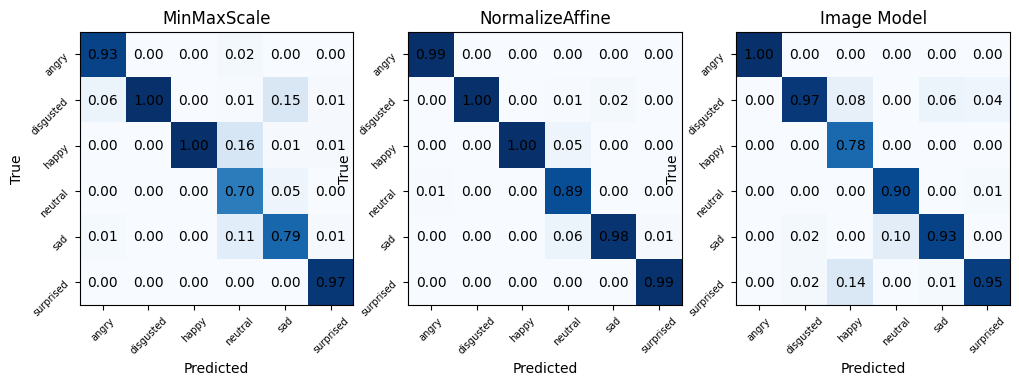

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(landmark_cm_minmax, cmap="Blues")
ax[0].set_title("MinMaxScale")
ax[0].set_xlabel("Predicted")
ax[0].set_xticks(range(len(id2label)))
ax[0].set_xticklabels(
    [id2label[i] for i in range(len(id2label))], rotation=45, fontsize=7
)
ax[0].set_yticks(range(len(id2label)))
ax[0].set_yticklabels(
    [id2label[i] for i in range(len(id2label))], rotation=45, fontsize=7
)
ax[0].set_ylabel("True")
ax[1].imshow(landmark_cm, cmap="Blues")
ax[1].set_title("NormalizeAffine")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("True")
ax[1].set_xticks(range(len(id2label)))
ax[1].set_xticklabels(
    [id2label[i] for i in range(len(id2label))], rotation=45, fontsize=7
)
ax[1].set_yticks(range(len(id2label)))
ax[1].set_yticklabels(
    [id2label[i] for i in range(len(id2label))], rotation=45, fontsize=7
)
ax[2].imshow(image_cm, cmap="Blues")
ax[2].set_title("Image Model")
ax[2].set_xlabel("Predicted")
ax[2].set_ylabel("True")
ax[2].set_xticks(range(len(id2label)))
ax[2].set_xticklabels(
    [id2label[i] for i in range(len(id2label))], rotation=45, fontsize=7
)
ax[2].set_yticks(range(len(id2label)))
ax[2].set_yticklabels(
    [id2label[i] for i in range(len(id2label))], rotation=45, fontsize=7
)

# plot text on top of the confusion matrix
for i in range(len(id2label)):
    for j in range(len(id2label)):
        ax[0].text(
            j,
            i,
            f"{landmark_cm_minmax[i][j]:.2f}",
            ha="center",
            va="center",
            color="black",
        )
        ax[1].text(
            j, i, f"{landmark_cm[i][j]:.2f}", ha="center", va="center", color="black"
        )
        ax[2].text(
            j, i, f"{image_cm[i][j]:.2f}", ha="center", va="center", color="black"
        )

# Measuring real time performances
For better readability, better consult the pdf

In [33]:
from torchvision import transforms
import mediapipe as mp

def mp_to_tensor(mp_landmarks, normalization_func, indices):
    landmarks = np.array([[l.x, l.y, l.z] for l in mp_landmarks.landmark])
    landmarks = normalization_func(landmarks, indices)
    return torch.tensor(landmarks, dtype=torch.float32).permute(1, 0)

def measure_fps1D(model, image, device, n=500, batch_size=1):
    mp_face_mesh = mp.solutions.face_mesh

    with mp_face_mesh.FaceMesh(
        max_num_faces=1,
        static_image_mode=False,
        refine_landmarks=True,
        min_detection_confidence=0.8,
        min_tracking_confidence=0.5,
    ) as face_mesh:
        with torch.no_grad():
            model = model.to(device)
            #warmup
            for _ in range(10):
                results = face_mesh.process(image)
                # Draw the face mesh annotations on the image.
                if results.multi_face_landmarks:
                    for face_landmarks in results.multi_face_landmarks:
                        sample = mp_to_tensor(face_landmarks, normalize_affine, indices)
                        break
                    sample = sample.repeat(batch_size, 1, 1).to(device)
                    x = model(sample)
                else:
                    return None
            
            start = time()
            for _ in tqdm(range(n)):
                results = face_mesh.process(image)
                # Draw the face mesh annotations on the image.
                if results.multi_face_landmarks:
                    for face_landmarks in results.multi_face_landmarks:
                        sample = mp_to_tensor(face_landmarks, normalize_affine, indices)
                        break
                    sample = sample.repeat(batch_size, 1, 1).to(device)
                    x = model(sample)
                else:
                    return None

    end = time()
    fps = n / (end - start)
    return fps


def measure_fps2D_pipeline(model, image, device, n, batch_size):
    transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((96, 96)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    
    image = cv2.imread("custom_dataset/test/video_dataset/happy/1725124508.75886.jpg")
    model.eval()
    model = model.to(device)
    toy = torch.rand((1, 3, 96, 96)).to(device)
    with torch.no_grad():
        #model warmup
        for _ in range(10):
            model(toy)
    mp_face_detection = mp.solutions.face_detection

    with torch.no_grad():
        with mp_face_detection.FaceDetection(min_detection_confidence=0.5) as face_detection:
            start = time()
            for _ in tqdm(range(n)):
                # Detect faces
                results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

                # Process each face detection result
                if results.detections:
                    for detection in results.detections:
                        # Get bounding box coordinates
                        bboxC = detection.location_data.relative_bounding_box
                        h, w, _ = image.shape
                        bbox = int(bboxC.xmin * w), int(bboxC.ymin * h), int(bboxC.width * w), int(bboxC.height * h)
                        
                        # Crop the face from the image
                        x, y, w, h = bbox
                        face_crop = image[y:y+h, x:x+w]
                        
                        t = transform(face_crop).unsqueeze(0).to(device)
                        t = t.repeat(batch_size, 1, 1, 1)
                        model(t)
            
            end = time()
        
    return n / (end - start)

In [46]:
#Measuring 2D baseline pipeline 
model = Net2D(len(label2id))
batches = [1, 10, 32, 64]
image = cv2.imread("databases/custom_dataset/test/video_dataset/happy/1725124508.75886.jpg")
fps = [measure_fps2D_pipeline(model, image, torch.device("cpu"), n=1000, batch_size=b) for b in batches]
#[68.39344500420057, 7.366701573941018, 1.2464071937556271, 0.8221476101789681] <- CPU
fps = [measure_fps2D_pipeline(model, image, torch.device("mps"), n=1000, batch_size=b) for b in batches]
#[138.77297189597718, 99.98506292332941, 34.854141254376934, 18.62257632626101] <- GPU (MPS)

In [ ]:
net = Net(len(label2id))
batches = [1, 10, 32, 64]
fps = [measure_fps1D(net, image, torch.device("cpu"), n=1000, batch_size=b) for b in batches]
fps #[202.31240694858502, 169.47757213376477, 23.39643861617474, 16.57796870967219] <- CPU
fps = [measure_fps1D(net, image, torch.device("mps"), n=1000, batch_size=b) for b in batches]
fps #[142.22277681543423, 151.31435710796376, 151.26796573614158, 153.65014448990402] <- GPU (MPS)

In [47]:
#PIPELINE 2D
device = "cpu"
batches = [1, 10, 32, 64]
fps_2d = [68.39344500420057, 7.366701573941018, 1.2464071937556271, 0.8221476101789681]

#PIPELINE 1D
"_________"
device = "cpu"
batches = [1, 10, 32, 64]
fps_1d = [202.31240694858502, 169.47757213376477, 23.39643861617474, 16.57796870967219]

In [48]:
import pandas as pd
import numpy as np

df = pd.DataFrame(columns = ["Batch Size", "FPS Baseline Model(CPU)", "FPS Landmark Model(CPU)", "Improvement"])
#Put an header to columsn from 2 to 5
for batch, f_base, f_land in zip(batches, fps_2d, fps_1d):
    improvement = (f_land- f_base) / f_base * 100
    improvement = f"{int(improvement)}%"
    f_base = np.round(f_base, 2)
    f_land = np.round(f_land, 2)
    df = pd.concat([df, pd.DataFrame([[batch, f_base, f_land, improvement]], columns=df.columns)], ignore_index=True)

latex_code = df_to_latex_table(df)
with open("pipeline_cpu_fps_comparison.tex", "w") as f:
    f.write(latex_code)
df

/var/folders/f1/mgyx72dd65b8kb__4m0rxs_w0000gn/T/ipykernel_59948/3092075280.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([[batch, f_base, f_land, improvement]], columns=df.columns)], ignore_index=True)


,Batch Size,FPS Baseline Model(CPU),FPS Landmark Model(CPU),Improvement
0,1,68.39,202.31,195%
1,10,7.37,169.48,2200%
2,32,1.25,23.40,1777%
3,64,0.82,16.58,1916%


In [49]:
#PIPELINE 2D
"_________"
device = "mps"
batches = [1, 10, 32, 64]
fps_2d = [138.77297189597718, 99.98506292332941, 34.854141254376934, 18.62257632626101]
#PIPELINE 1D
device = "mps"
batches = [1, 10, 32, 64]
fps_1d = [142.22277681543423, 151.31435710796376, 151.26796573614158, 153.65014448990402]

In [50]:
import pandas as pd
import numpy as np

df = pd.DataFrame(columns = ["Batch Size", "FPS Baseline Model(GPU)", "FPS Landmark Model(GPU)", "Improvement"])
#Put an header to columsn from 2 to 5
for batch, f_base, f_land in zip(batches, fps_2d, fps_1d):
    improvement = (f_land- f_base) / f_base * 100
    improvement = f"{int(improvement)}%"
    f_base = np.round(f_base, 2)
    f_land = np.round(f_land, 2)
    df = pd.concat([df, pd.DataFrame([[batch, f_base, f_land, improvement]], columns=df.columns)], ignore_index=True)

latex_code = df_to_latex_table(df)
with open("pipeline_gpu_fps_comparison.tex", "w") as f:
    f.write(latex_code)
df

/var/folders/f1/mgyx72dd65b8kb__4m0rxs_w0000gn/T/ipykernel_59948/2383807343.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([[batch, f_base, f_land, improvement]], columns=df.columns)], ignore_index=True)


,Batch Size,FPS Baseline Model(GPU),FPS Landmark Model(GPU),Improvement
0,1,138.77,142.22,2%
1,10,99.99,151.31,51%
2,32,34.85,151.27,334%
3,64,18.62,153.65,725%


In [ ]:
import mediapipe as mp

def measure_fps(model, device, n=500, input_shape=(10, 3, 100)):
    model = model.to(device)
    model.eval()
    x = torch.randn(input_shape).to(device)
    with torch.no_grad():
        #warmup
        for _ in range(10):
            model(x)
        
        start = time()
        for _ in tqdm(range(n)):
            model(x)

    end = time()
    fps = n / (end - start)
    return fps

In [52]:
model = Net2D(len(label2id))
batches = [1, 10, 32, 64]
fps = [measure_fps(model, torch.device("cpu"), 1000, input_shape=(b, 3, 96, 96)) for b in batches]
fps #[108.58051083298152, 8.084045482940153, 1.2735955254346465, 0.8356541022294175] <- CPU
fps = [measure_fps(model, torch.device("mps"), 1000, input_shape=(b, 3, 96, 96)) for b in batches]
fps #[955.6408800554842, 121.78695494342834, 37.02012162567491, 19.464261776033048] <- GPU (MPS)

In [53]:
#RAW MODEL 2D
device = "cpu"
batches = [1, 10, 32, 64]
fps_2d = [108.58051083298152, 8.084045482940153, 1.2735955254346465, 0.8356541022294175]
"------------------------"
#RAW MODEL 1D
device = "cpu"
batches = [1, 10, 32, 64]
fps_1d = [3427.4161982298688, 737.4745665321234, 25.515475781652437, 17.711412455525103]

In [54]:
import pandas as pd
import numpy as np

df = pd.DataFrame(columns = ["Batch Size", "FPS Baseline Model(CPU)", "FPS Landmark Model(CPU)", "Improvement"])
#Put an header to columsn from 2 to 5
for batch, f_base, f_land in zip(batches, fps_2d, fps_1d):
    improvement = (f_land- f_base) / f_base * 100
    improvement = f"{int(improvement)}%"
    f_base = np.round(f_base, 2)
    f_land = np.round(f_land, 2)
    df = pd.concat([df, pd.DataFrame([[batch, f_base, f_land, improvement]], columns=df.columns)], ignore_index=True)

latex_code = df_to_latex_table(df)
with open("raw_cpu_fps_comparison.tex", "w") as f:
    f.write(latex_code)
df

/var/folders/f1/mgyx72dd65b8kb__4m0rxs_w0000gn/T/ipykernel_59948/449645067.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([[batch, f_base, f_land, improvement]], columns=df.columns)], ignore_index=True)


,Batch Size,FPS Baseline Model(CPU),FPS Landmark Model(CPU),Improvement
0,1,108.58,3427.42,3056%
1,10,8.08,737.47,9022%
2,32,1.27,25.52,1903%
3,64,0.84,17.71,2019%


In [55]:
#RAW MODEL 2D
device = "mps"
batches = [1, 10, 32, 64]
fps_2d = [955.6408800554842, 121.78695494342834, 37.02012162567491, 19.464261776033048]
"------------------------"
#RAW MODEL 1 D
device = "mps"
batches = [1, 10, 32, 64]
fps_1d = [858.8340156343967, 803.813101893845, 786.2544047863189, 751.5107514329899]

In [56]:
import pandas as pd
import numpy as np

df = pd.DataFrame(columns = ["Batch Size", "FPS Baseline Model(GPU)", "FPS Landmark Model(GPU)", "Improvement"])
#Put an header to columsn from 2 to 5
for batch, f_base, f_land in zip(batches, fps_2d, fps_1d):
    improvement = (f_land- f_base) / f_base * 100
    improvement = f"{int(improvement)}%"
    f_base = np.round(f_base, 2)
    f_land = np.round(f_land, 2)
    df = pd.concat([df, pd.DataFrame([[batch, f_base, f_land, improvement]], columns=df.columns)], ignore_index=True)

latex_code = df_to_latex_table(df)
with open("raw_gpu_fps_comparison.tex", "w") as f:
    f.write(latex_code)
df

/var/folders/f1/mgyx72dd65b8kb__4m0rxs_w0000gn/T/ipykernel_59948/3617360078.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([[batch, f_base, f_land, improvement]], columns=df.columns)], ignore_index=True)


,Batch Size,FPS Baseline Model(GPU),FPS Landmark Model(GPU),Improvement
0,1,955.64,858.83,-10%
1,10,121.79,803.81,560%
2,32,37.02,786.25,2023%
3,64,19.46,751.51,3760%


# Demo Video for visualization

In [36]:
import cv2
import mediapipe as mp
from time import time
from mediapipe.framework.formats import landmark_pb2
import torch.nn.functional as F
import IPython.display as display
from PIL import Image
from utils import y_scale, fast_draw, normalize_face, Net, get_indices_subset, draw_landmarks, normalize_affine
import torch
from torchvision.datasets import ImageFolder
import json
import numpy as np

In [37]:
# getting label2id from image folders
train_path = "databases/custom_dataset/train/cropped_dataset2/"
landmark_test_path = "databases/custom_dataset/test/landmark_dataset.json"
train_dataset = ImageFolder(train_path)
label2id = train_dataset.class_to_idx
id2label = {v: k for k, v in label2id.items()}
id2label

{0: 'angry',
 1: 'disgusted',
 2: 'happy',
 3: 'neutral',
 4: 'sad',
 5: 'surprised'}

In [38]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh


def mp_to_tensor(mp_landmarks, normalization_func, indices):
    landmarks = np.array([[l.x, l.y, l.z] for l in mp_landmarks.landmark])
    landmarks = normalization_func(landmarks, indices)
    return torch.tensor(landmarks, dtype=torch.float32).permute(1, 0)

In [39]:
device = torch.device("cpu")
model = Net(len(label2id))

# Loading models to device
model = model.to(device)

# Loading state dicts
model.load_state_dict(
    torch.load("models/Net-affine-finetuning.pth", weights_only=True)
)

<All keys matched successfully>

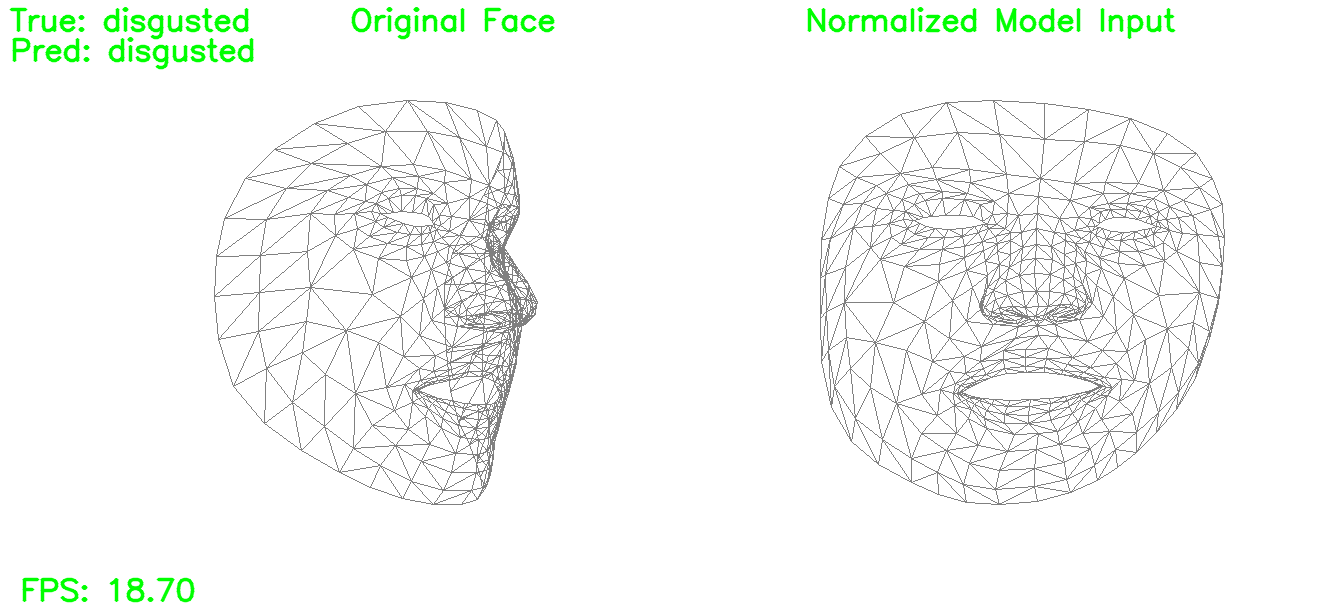

In [40]:
#normalization_func = normalize_face
normalization_func = normalize_affine
landmarks = json.load(open(landmark_test_path))["Nic"]
normalization_func = normalize_affine
indices = get_indices_subset()
batch_size = 5
batch = torch.rand(batch_size, 3, len(indices)).to(device)
count = 0
start = time()
fps = 0

for data in landmarks:
    landmark = np.array(data["landmarks"])
    emotion = data["emotion"]

    frame = np.ones((405, 720, 3), dtype=np.uint8) * 255
    norm_frame = np.ones((405, 405, 3), dtype=np.uint8) * 255
    normalized_landmark = torch.tensor(
        normalization_func(landmark, indices), dtype=torch.float32
    ).permute(1, 0)

    l_tensor = normalized_landmark.unsqueeze(0).to(device)
    batch = torch.cat((batch[1:], l_tensor))

    with torch.no_grad():
        output = model(batch)
        output = F.softmax(output, 1)
        scores, labels = output.max(1)
        score, idx = scores.max(0)
        label = id2label[labels[idx].item()]
    
    frame = draw_landmarks(frame, y_scale(landmark), already_normalized=False)
    if indices is None:
        norm_frame = draw_landmarks(norm_frame, normalized_landmark.numpy(), already_normalized=False)
    else:
        #norm_frame = fast_draw(norm_frame, normalized_landmark)
        normalized_landmark = normalization_func(landmark, None)
        norm_frame = draw_landmarks(norm_frame, normalized_landmark, already_normalized=False)
        
    frame = np.concatenate((frame, norm_frame), axis=1)
    frame = cv2.copyMakeBorder(
        frame,
        100,
        100,
        100,
        100,
        borderType=cv2.BORDER_CONSTANT,
        value=[255, 255, 255],  # Color of the padding (black)
    )

    cv2.putText(
        frame,
        f"True: {emotion}",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0),
        2,
        cv2.LINE_AA,
    )
    if score > 0.5:
        cv2.putText(
            frame,
            f"Pred: {label}",
            (10, 60),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 255, 0),
            2,
            cv2.LINE_AA,
        )

    cv2.putText(
        frame,
        f"Original Face",
        (350, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0),
        2,
        cv2.LINE_AA,
    )

    cv2.putText(
        frame,
        f"Normalized Model Input",
        (400 + 405, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0),
        2,
        cv2.LINE_AA,
    )
    if count < 30:
        count += 1
    else:
        fps = 30 / (time() - start)
        start = time()
        count = 0

    cv2.putText(
        frame,
        f"FPS: {fps:.2f}",
        (20, 600),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0),
        2,
        cv2.LINE_AA,
    )

    frame = Image.fromarray(frame)

    # Display the frame
    display.clear_output(wait=True)
    display.display(frame)


cv2.destroyAllWindows()